# PСA и t-SNE для отобранных абстрактов

Считаем все отбранные абстракты

In [1]:
import numpy as np
import torch
from transformers import *
import pandas as pd
import re

In [2]:
table = pd.read_csv('abstr-cites.csv')  

In [3]:
text_abstr = [table['Abstract'][i] for i in range(len(table['Abstract']))]

In [4]:
text_abstr

['<http://ma-graph.org/entity/587> <http://purl.org/dc/terms/abstract> "In an ecological study of the freshwater sponge, Metania spinata (Metaniidae), in Lagoa Dourada reservoir, River Lobo watershed, Brazil, we found substantial seasonal variation in biomass and productivity and related them to environmental variables (climatic and hydrologic). Sponges were sampled monthly by the quadrat technique, from March 1989 to April 1990, at two sites near the dam in order to estimate the seasonal population dynamics. Biomass peaks were found in spring/summer, with gemmulation occurring from March to September (autumn/winter). The minimal production of M. spinata during the period of study was estimated as the difference between the highest and the lowest biomass, 33.54 gAFDM m-2 yr-1, yielding a P/B ratio of 2.72."^^<http://www.w3.org/2001/XMLSchema#string> .\n',
 '<http://ma-graph.org/entity/763> <http://purl.org/dc/terms/abstract> "PURPOSE. To establish the in vitro action spectrum for acute

In [5]:
ll = len(text_abstr)

Инициализируем необходимые модели

In [6]:
model_class = BertModel
tokenizer_class = BertTokenizer
pretrained_weights = 'bert-base-uncased'
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to('cuda')    

Функция, удалаюящая все ненужные символы из текста.

In [7]:
def clean_txt(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    cleanr = re.compile('{.*?}')
    cleantext = re.sub(cleanr, ' ', str(cleantext))
    
    cleaned = re.sub(r'[\'|"|#|^]',r'',cleantext)
    cleaned = re.sub(r'[)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    
    return cleaned

Функция, обрезающая абстракт до 100 слов

In [8]:
def cut_line(line):
    temp = line.split(' ')
    temp = temp[0:100]#108]
    t = ''
    for i in temp:
        t = t+ i+' '
    return(t)

Проверим работу tokenizer'a:

In [9]:
def tokenize_data(data):
    tokenize_dt = []
    n = 1
    for line in data:
       # if len(tokenize_dt) < n:
       # print(cut_line(line))
        if n:
          #  print(cut_line(line))#clean_txt(line)))
            print(cut_line(clean_txt(line)))#clean_txt(line))))
            n = 0
        tokenize_dt.append(tokenizer.encode((cut_line(clean_txt(line))), add_special_tokens=True))
    return tokenize_dt

In [10]:
tokenize_dt = tokenize_data(text_abstr)

In an ecological study of the freshwater sponge, Metania spinata  Metaniidae , in Lagoa Dourada reservoir, River Lobo watershed, Brazil, we found substantial seasonal variation in biomass and productivity and related them to environmental variables  climatic and hydrologic . Sponges were sampled monthly by the quadrat technique, from March 1989 to April 1990, at two sites near the dam in order to estimate the seasonal population dynamics. Biomass peaks were found in spring summer, with gemmulation occurring from March to September  autumn winter . The minimal production of M. spinata during the period of study was estimated 


In [11]:
print(tokenize_dt[0])

[101, 1999, 2019, 12231, 2817, 1997, 1996, 12573, 25742, 1010, 18804, 6200, 6714, 6790, 18804, 3490, 6096, 1010, 1999, 2474, 3995, 2050, 2079, 4648, 2850, 8071, 1010, 2314, 8840, 5092, 12547, 1010, 4380, 1010, 2057, 2179, 6937, 12348, 8386, 1999, 28148, 1998, 15836, 1998, 3141, 2068, 2000, 4483, 10857, 27301, 1998, 18479, 27179, 1012, 25742, 2015, 2020, 18925, 7058, 2011, 1996, 17718, 8609, 6028, 1010, 2013, 2233, 2960, 2000, 2258, 2901, 1010, 2012, 2048, 4573, 2379, 1996, 5477, 1999, 2344, 2000, 10197, 1996, 12348, 2313, 10949, 1012, 28148, 11373, 2020, 2179, 1999, 3500, 2621, 1010, 2007, 17070, 12274, 13490, 10066, 2013, 2233, 2000, 2244, 7114, 3467, 1012, 1996, 10124, 2537, 1997, 1049, 1012, 6714, 6790, 2076, 1996, 2558, 1997, 2817, 2001, 4358, 102]


In [12]:
np.shape(tokenize_dt)

(408,)

In [13]:
tokenizer.sep_token_id

102

In [14]:
np.asarray(tokenize_dt).shape

(408,)

In [15]:
print(tokenize_dt[2])

[101, 1996, 3800, 1997, 2023, 2817, 2003, 2000, 4503, 1037, 4083, 6994, 2005, 2152, 2082, 2493, 5702, 1996, 4045, 5919, 1997, 2592, 1998, 4807, 6125, 1012, 2062, 4919, 1010, 2057, 3579, 2006, 1996, 3937, 6481, 1997, 2897, 16744, 2004, 1996, 6614, 2000, 4503, 2256, 4083, 6994, 1012, 2256, 6994, 3957, 2493, 2398, 1011, 2006, 3325, 2000, 2393, 3305, 1996, 3937, 6481, 1997, 2897, 16744, 1012, 1012, 102]


Создадим пары абстрактов и токенезируем их

In [16]:
pairs = []

In [17]:
length_limit = 200

In [18]:
ll = 200
cites_all = []
for ifirst in range(ll):
    for isecond in range(ll):
        f = 0                    
        concantenated = cut_line(clean_txt(text_abstr[ifirst])) + cut_line(clean_txt(text_abstr[isecond]))
        tokenized = tokenizer.encode(concantenated)
       # tokenized = tokenized if len(tokenized)<length_limit else tokenized[:length_limit]
        cites_all.append(f)
        pairs.append(tokenized)
        if len(pairs)>35000:
            break

In [19]:
len(pairs)

35025

Получим эмбеддинги токенизированных пар:

In [20]:
use_pooler_output=False

In [21]:
def get_embeddings(token_list):
    output = []
    vectors_idx =  [torch.LongTensor(x) for x in token_list] 
    vectors_idx = torch.nn.utils.rnn.pad_sequence(vectors_idx, batch_first=True)
    vectors_tensor = torch.utils.data.DataLoader(torch.LongTensor(vectors_idx).to('cuda'), batch_size=16)
    print(len(vectors_tensor))
    i = 0
    for vvv  in vectors_tensor:
        print(i)
        i = i + 1
        with torch.no_grad():
            encoded_layers, pooler_output = model(vvv)
            if use_pooler_output:
                res = pooler_output.cpu().numpy()
            else:
                res = encoded_layers.cpu().numpy()[:, 0, :]
        output.append(res)
    print('До vstack: ', np.shape(output))
    out = np.vstack(output)
    print('После vstack: ', np.shape(out)) 
    return out

In [22]:
emb_pairs = get_embeddings(pairs)

2190
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


Применим к эмбеддигам пар PCA и визуализируем результат:

In [23]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [28]:
pca = PCA(n_components=2)
#100 предложений use_pooler_output = True
result = pca.fit_transform(emb_pairs)

In [29]:
plt.scatter(result.T[0], result.T[1])

Применим к эмбеддигам пар t-SNE и визуализируем результат:

In [24]:
from sklearn.manifold import TSNE

In [25]:
X_emb = TSNE(n_components=2).fit_transform(emb_pairs)
print(X_emb)
plt.scatter(X_emb.T[0], X_emb.T[1])

[[ 73.01626     13.465744  ]
 [-55.471634   -24.506166  ]
 [ 45.192463    -0.11233319]
 ...
 [ 71.97588     14.989961  ]
 [ 72.663376    14.45067   ]
 [ 71.40131     14.670655  ]]


## XLNet

Исследуем теперь полный текст абстрактов. Для этого заменим модель на XLNet, отредактируем представленный выше код для работы с этой моделью, и также нарисуем визуализацию PCA и t-SNE

In [6]:
from transformers import XLNetTokenizer, XLNetForTokenClassification
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetForTokenClassification.from_pretrained('xlnet-large-cased')
model = model.to('cuda')  

In [7]:
def tokenize_data(data):
    tokenize_dt = []
    n = 200
    for line in data:
        if len(tokenize_dt) < n:
       # print(cut_line(line))
            tokenize_dt.append(tokenizer.encode(clean_txt(line), add_special_tokens=True))
    return tokenize_dt

In [8]:
tokenize_dt = tokenize_data(text_abstr)

In [9]:
np.shape(tokenize_dt)

(200,)

In [10]:
tokenizer.sep_token_id

4

In [11]:
np.asarray(tokenize_dt).shape

(200,)

In [12]:
print(tokenize_dt[2])

[32, 1872, 20, 52, 757, 27, 22, 1627, 24, 1899, 2827, 28, 227, 297, 466, 5403, 18, 3072, 3878, 20, 229, 21, 3056, 3986, 1154, 3653, 80, 1304, 31, 18, 1949, 4375, 20, 1090, 17622, 34, 18, 4308, 22, 1627, 120, 1899, 2827, 1146, 2827, 1849, 466, 853, 13, 253, 656, 22, 222, 1111, 18, 1949, 4375, 20, 1090, 17622, 4, 3]


In [13]:
pairs = []
ll = 200
for ifirst in range(ll):
    for isecond in range(ll):
        concantenated = clean_txt(text_abstr[ifirst]) + clean_txt(text_abstr[isecond])
        tokenized = tokenizer.encode(concantenated)
       # tokenized = tokenized if len(tokenized)<length_limit else tokenized[:length_limit]
        pairs.append(tokenized)
        if len(pairs)>35000:
            break

In [14]:
len(pairs)

35025

In [15]:
use_pooler_output=False

In [16]:
def get_embeddings(token_list):
    output = []
    vectors_idx =  [torch.LongTensor(x) for x in token_list] 
    vectors_idx = torch.nn.utils.rnn.pad_sequence(vectors_idx, batch_first=True)
    vectors_tensor = torch.utils.data.DataLoader(torch.LongTensor(vectors_idx).to('cuda'), batch_size=4)
    print(len(vectors_tensor))
    i = 0
    for vvv  in vectors_tensor:
        print(i)
        i = i + 1
        with torch.no_grad():
           # encoded_layers, pooler_output = model(vvv)
           # if use_pooler_output:
           #     res = pooler_output.cpu().numpy()
           # else:
           #     res = encoded_layers.cpu().numpy()[:, 0, :]
            output_layer = model(vvv)
            logits = output_layer[0]
            res = logits.detach().cpu().numpy()
        output.append(res)
    print('До vstack: ', np.shape(output))
    out = np.vstack(output)
    print('После vstack: ', np.shape(out)) 
    return out

In [17]:
emb_pairs = get_embeddings(pairs)

8757
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118


3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757


5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396


6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035


8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674


In [24]:
np.shape(emb_pairs[:,:,0])

(35025, 2152)

In [35]:
emb_pairs

array([[[ 0.4318348 ,  0.43204215],
        [ 0.03200281, -0.26101112],
        [-0.86633563,  1.0268734 ],
        ...,
        [-0.90130216,  0.7059753 ],
        [-0.8916106 ,  0.7280518 ],
        [-0.50961447,  0.75887674]],

       [[ 0.38241327,  0.6401738 ],
        [ 0.37690687,  0.5865791 ],
        [-0.5789296 ,  0.71491075],
        ...,
        [-0.83416104,  0.9562175 ],
        [-0.7558853 ,  0.84243613],
        [-0.4613762 ,  0.80427706]],

       [[ 0.515947  ,  0.96102977],
        [-0.23787731,  0.30794704],
        [-0.5955856 ,  0.8714767 ],
        ...,
        [-1.4242016 ,  1.0875664 ],
        [-1.4072857 ,  1.1190706 ],
        [-0.95866805,  1.1068188 ]],

       ...,

       [[ 0.54801   , -0.23262288],
        [ 0.8061073 ,  0.10306585],
        [ 0.5860879 , -0.3271718 ],
        ...,
        [-0.61842346,  0.4177445 ],
        [-0.5098007 ,  0.5077648 ],
        [-0.34412175,  0.64803976]],

       [[ 0.19637534,  0.52526426],
        [ 1.4462986 ,  0.56

In [21]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [25]:
pca = PCA(n_components=2)
#100 предложений use_pooler_output = True
result = pca.fit_transform(emb_pairs[:,:,0])
#plt.plot(matrix, 'bo', matrix, 'k') 
#plt.hlines(0,0, len(matrix),'r')

#plt.grid()
#plt.show()

In [26]:
plt.scatter(result.T[0], result.T[1])

In [27]:
pca = PCA(n_components=2)
#100 предложений use_pooler_output = True
result = pca.fit_transform(emb_pairs[:,:,1])

In [28]:
plt.scatter(result.T[0], result.T[1])

In [18]:
from sklearn.manifold import TSNE

[[-11.585766   35.51898  ]
 [ -3.657928   42.645653 ]
 [-14.247249   30.520338 ]
 ...
 [ -3.6732962  38.403564 ]
 [-32.082413   36.857597 ]
 [ -8.767858   36.405087 ]]


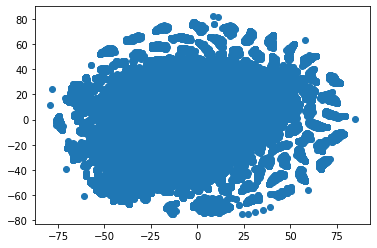

In [30]:
X_emb = TSNE(n_components=2).fit_transform(emb_pairs[:,:,0])
print(X_emb)
plt.scatter(X_emb.T[0], X_emb.T[1])

[[23.401306  58.00703  ]
 [20.053875  58.369102 ]
 [18.009464  56.451023 ]
 ...
 [41.441673   9.112716 ]
 [34.474567  -4.9621387]
 [41.414337   9.00094  ]]


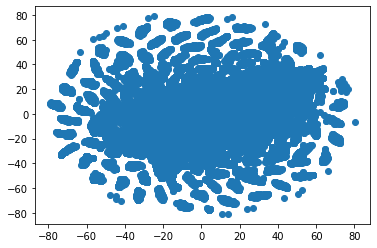

In [31]:
X_emb = TSNE(n_components=2).fit_transform(emb_pairs[:,:,1])
print(X_emb)
plt.scatter(X_emb.T[0], X_emb.T[1])